In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pygame

import os

#Tensorflow
import tensorflow.keras
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, GRU, Dropout

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import Reshape

#Sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

#Gpu
from numba import cuda

#bibliotecas para plotar graficos do keras
import pydot as pyd
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

from tabulate import tabulate

#checa a GPU e limpa ela
meuPc = cuda.get_current_device()
print(meuPc)
meuPc.reset()
!nvidia-smi

pygame 2.4.0 (SDL 2.26.4, Python 3.10.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


2023-07-01 22:12:56.397567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 22:12:57.507268: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<CUDA device 0 'b'NVIDIA GeForce MX110''>
/bin/bash: /home/higor/miniconda3/envs/rna/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sat Jul  1 22:12:59 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX110            Off| 00000000:01:00.0 Off |                  N/A |
| N/A   70C    P0               N/A /  N/A|      6MiB /  2048MiB |      1%      Default

In [2]:
nomes_colunas = ['semanas', 'mais1ano', '1a4', '5a9', '10a14', '15a19', '20a34', '35a49', '50a64', '65a79', '80mais', 'total']
nomes_colunas2 = ['mais1ano', '1a4', '5a9', '10a14', '15a19', '20a34', '35a49', '50a64', '65a79', '80mais', 'total']
dados = pd.read_csv('datasets/dataDengue.csv', sep=';', names=nomes_colunas)

dados = dados.drop(['semanas'], axis=1)

#convertando os dados para numeros inteiros
dados = dados.astype('float')     #mudei pra float pq vai ajudar nas contas

#separando nomes das colunas
x_names = [nomes_colunas[1:]]

#preparando o shape para usar no keras

serie = dados[nomes_colunas2].values.reshape(-1, 11)

print(serie.shape)
dados.head(15)

(847, 11)


,mais1ano,1a4,5a9,10a14,15a19,20a34,35a49,50a64,65a79,80mais,total
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Os dados 0 podem fornecer dados importantes sobre cada faixa etária, mas no pré-processamento de dados podem ser interpretados incorretamente, pois os dados 0 podem ser interpretados como dados ausentes, o que pode afetar o modelo de aprendizado de máquina. Podemos tentar substituir por dados especiais ou usar mascaras de sequencia. so vou saber quando ver a lstm funcionando (e deu bom)

In [3]:
serie[:14]     #se observar no dataframe acima ta puxando tudo ate a 15 semana

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 3., 2., 0., 0., 7.],
       [0., 0., 0., 1., 1., 4., 2., 0., 0., 0., 8.]])

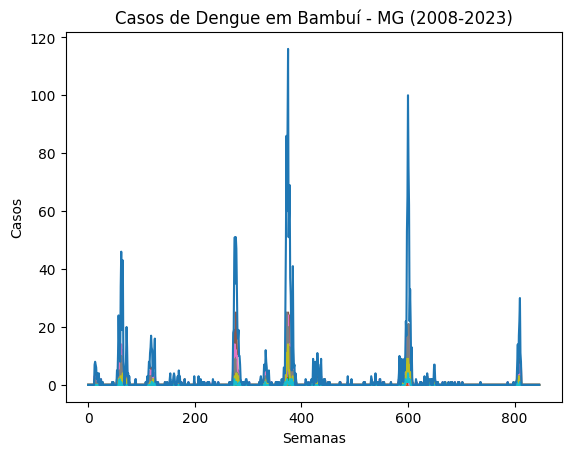

In [4]:
plt.plot(serie)
plt.xlabel('Semanas')
plt.ylabel('Casos')
plt.title('Casos de Dengue em Bambuí - MG (2008-2023)')
plt.show()

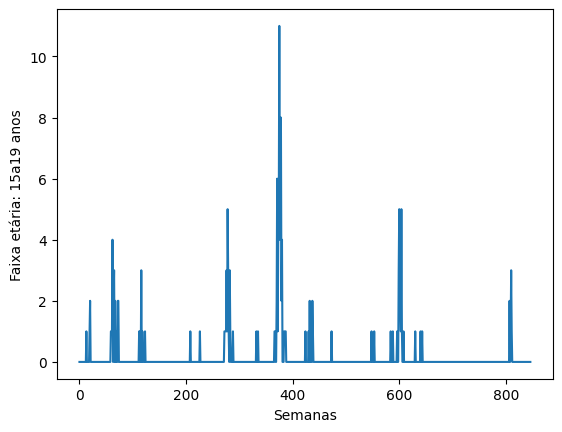

In [5]:
def plotFxEtaria(serie, coluna):     #funcao para plotar grafico de uma faixa etaria
    plt.plot(serie)
    plt.xlabel("Semanas")
    plt.ylabel("Faixa etária: "+str(coluna)+" anos")
    plt.show()

plotFxEtaria(serie[:, 3], '15a19')

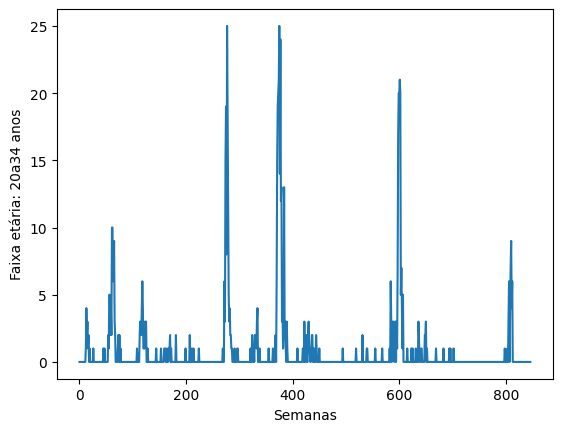

In [6]:
plotFxEtaria(serie[:, 5], '20a34')

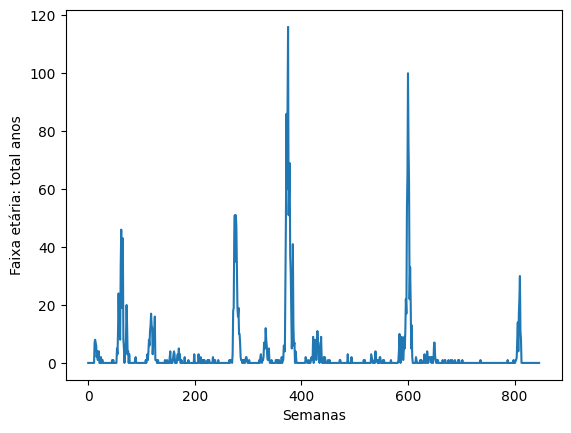

In [7]:
plotFxEtaria(serie[:, 10], 'total')


In [8]:
def sumarizacao(serie, column):       #algumas estatisticas basicas para cada coluna (esta ok)
    stats = []

    maximum = round(np.max(serie), 2)
    minimum = round(np.min(serie), 2)
    mean = round(np.mean(serie), 2)
    median = round(np.median(serie), 2)
    std = round(np.std(serie), 2)
    stats.append([column, maximum, minimum, mean, median, std])

    headers = ['Coluna', 'Máximo', 'Mínimo', 'Média', 'Mediana', 'Desvio Padrão']

    table = tabulate(stats, headers, tablefmt="pipe")
    print(table)

sumarizacao(serie[:, 5], '20a34')

| Coluna   |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:---------|---------:|---------:|--------:|----------:|----------------:|
| 20a34    |       25 |        0 |    0.89 |         0 |            3.04 |


In [9]:
sumarizacao(serie[:, 10], 'total')

| Coluna   |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:---------|---------:|---------:|--------:|----------:|----------------:|
| total    |      116 |        0 |     3.2 |         0 |           10.86 |


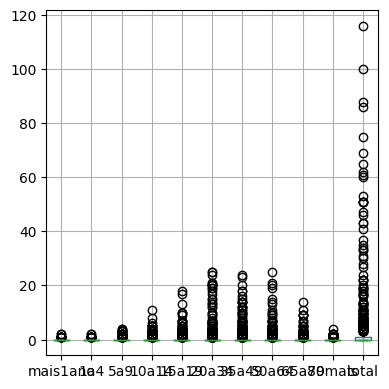

In [10]:
#mostrando todos boxplots das faixas etarias
dados.boxplot(column=nomes_colunas2, figsize=(4, 4))
plt.tight_layout()
plt.show()

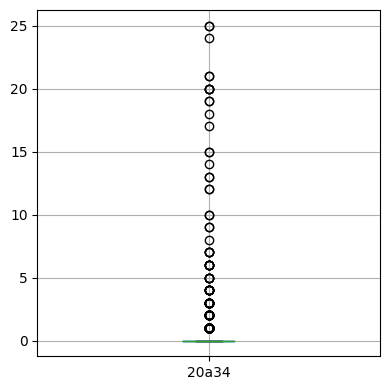

In [11]:
dados.boxplot(column='20a34', figsize=(4, 4))
plt.tight_layout()
plt.show()

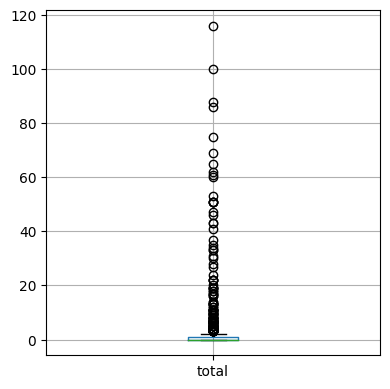

In [12]:
dados.boxplot(column='total', figsize=(4, 4))
plt.tight_layout()
plt.show()

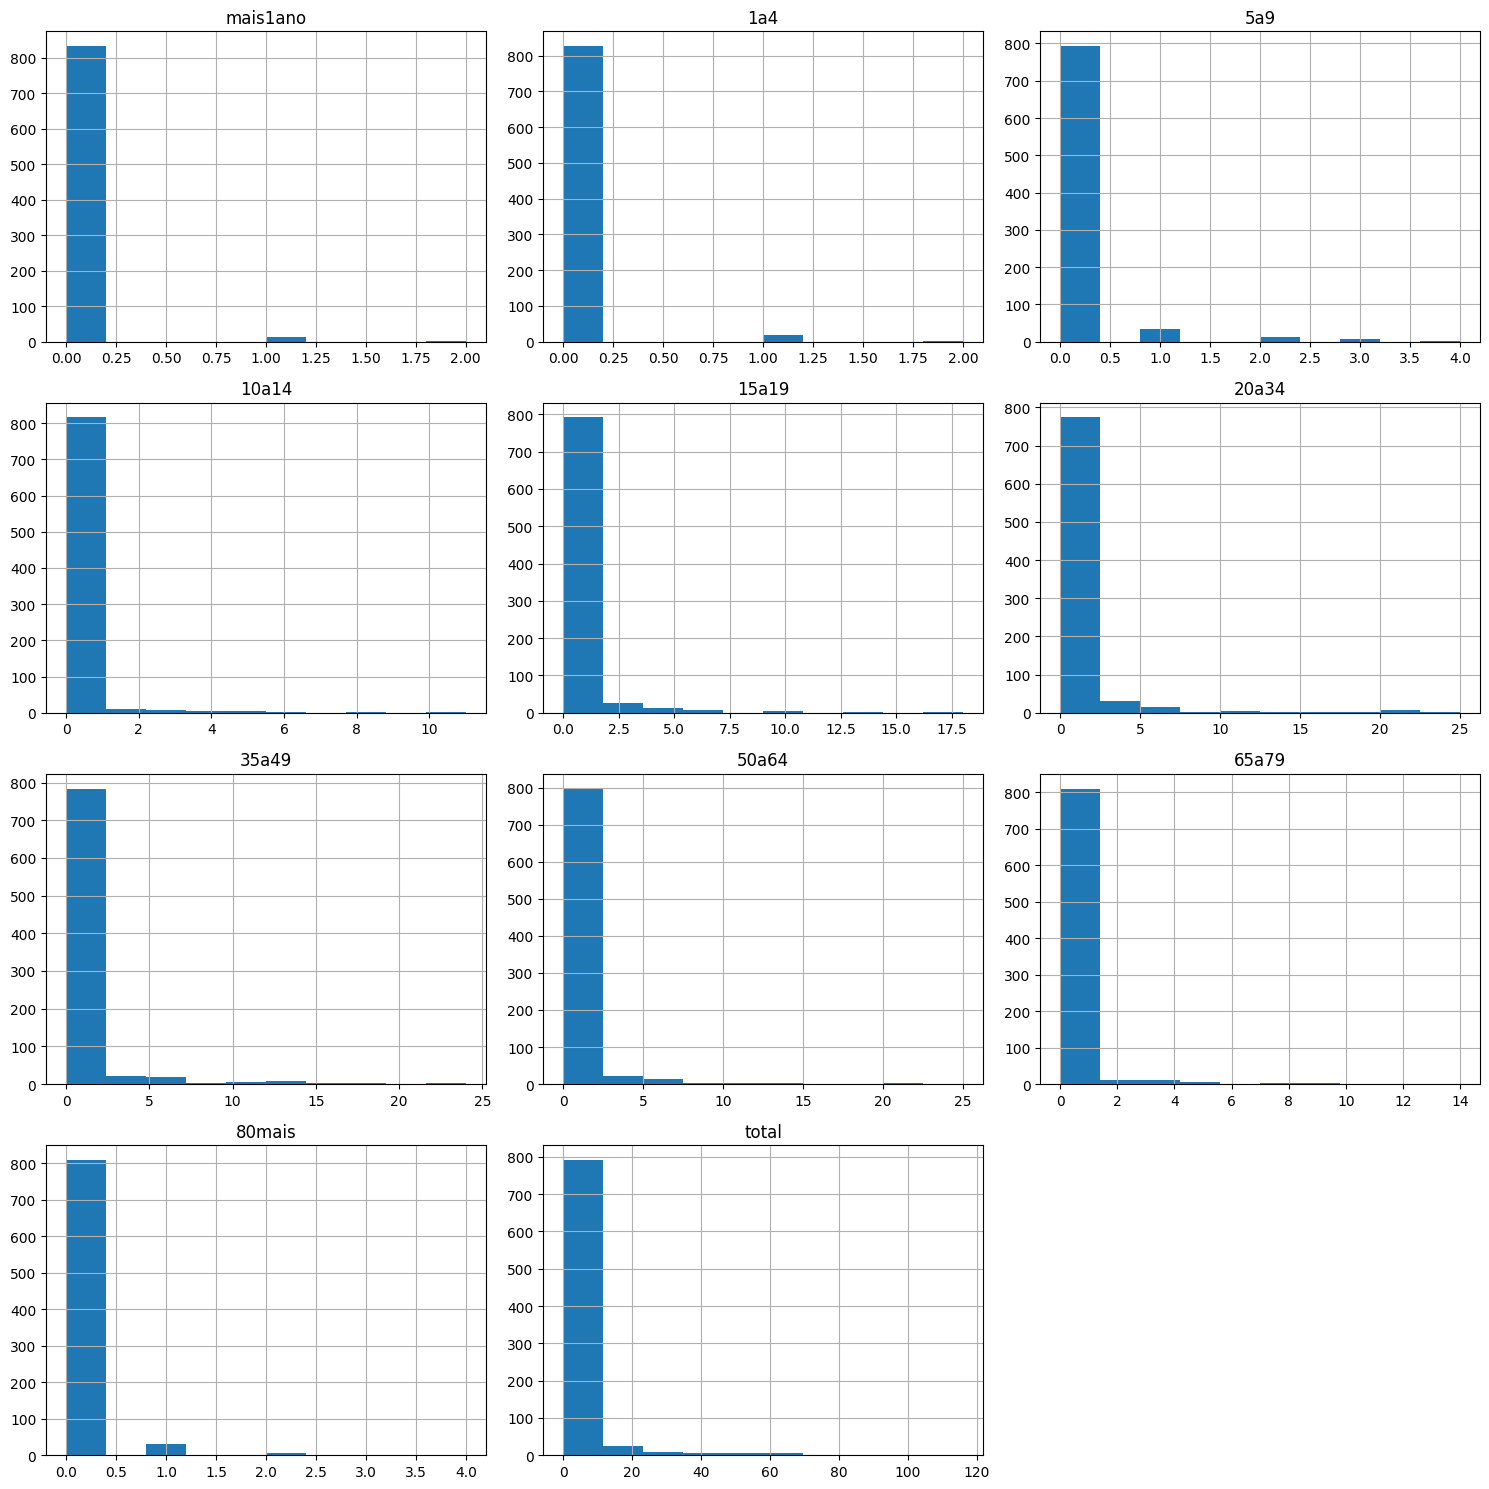

In [13]:
dados.hist(column=nomes_colunas2, figsize=(15, 15))    #mostrando todos os histogramas das faixas etarias semana(y)  casos(x)
plt.tight_layout()
plt.show()

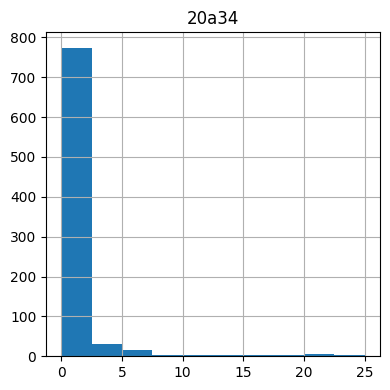

In [14]:
dados.hist(column='20a34', figsize=(4, 4))     #mostrando histograma da faixa etaria 20a34
plt.tight_layout()
plt.show()


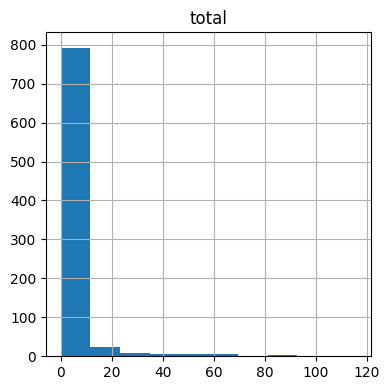

In [15]:
dados.hist(column='total', figsize=(4, 4))     
plt.tight_layout()
plt.show()


In [16]:
faltantes = dados.isnull().sum()     #verificando se tem dados faltantes
print(faltantes)

mais1ano    0
1a4         0
5a9         0
10a14       0
15a19       0
20a34       0
35a49       0
50a64       0
65a79       0
80mais      0
total       0
dtype: int64


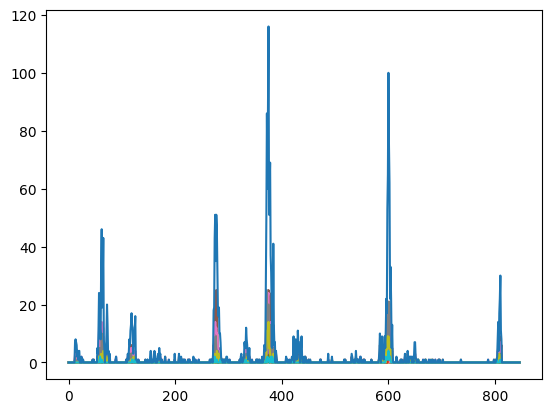

In [17]:
plt.plot(serie)

In [18]:
#normalizando os dados para ficar entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
serie_norm = scaler.fit_transform(serie)

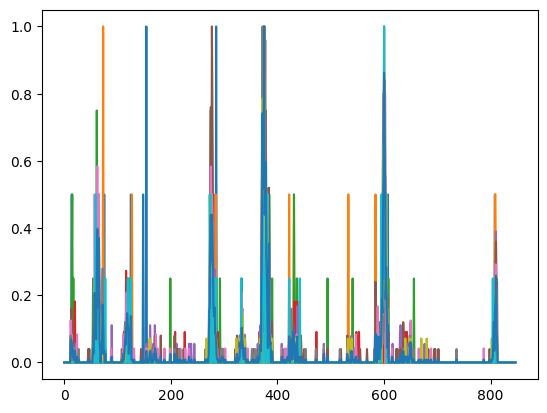

In [19]:
plt.plot(serie_norm)

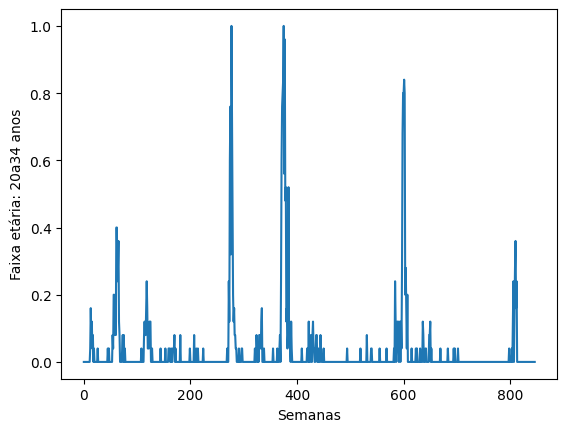

In [20]:
plotFxEtaria(serie_norm[:, 5], '20a34')

In [21]:
sumarizacao(serie_norm[:, 5], '20a34')

| Coluna   |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:---------|---------:|---------:|--------:|----------:|----------------:|
| 20a34    |        1 |        0 |    0.04 |         0 |            0.12 |


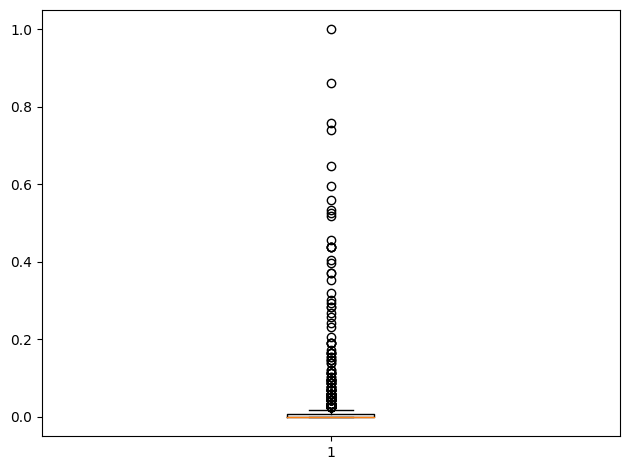

In [22]:
#plotando boxplot da faixa etaria 
plt.boxplot(serie_norm[:, 10])
plt.tight_layout()
plt.show()


In [23]:
#separando os dados de treino e teste (70% treino, 15 teste e 15 validação)
x_treino, x_teste = train_test_split(serie_norm, test_size=0.3, shuffle=False)
x_teste, x_val = train_test_split(x_teste, test_size=0.5, shuffle=False)

print(x_treino.shape)
print(x_teste.shape)
print(x_val.shape)

(592, 11)
(127, 11)
(128, 11)


In [24]:
#função para criar janelas de tempo(janelas moveis) para o modelo
def janelas(serie, janela):
    x = []
    y = []

    for i in range(len(serie) - janela - 1):
        x.append(serie[i:(i + janela)])
        y.append(serie[(i + janela)])

    return np.array(x), np.array(y)

janela = 4
x_treino, y_treino = janelas(x_treino, janela)
x_teste, y_teste = janelas(x_teste, janela)
x_val, y_val = janelas(x_val, janela)

In [25]:
print(x_treino.shape)  #587(pq é 1 semana, se fosse 2 era 587/2) amostras de treinamento, cada uma com 4 janelas de tempo e 11 características
print(y_treino.shape) #essas saídas são para cada amostra individual, elas têm apenas duas dimensões, com o primeiro eixo representando o número de amostras (no caso, 587) e o segundo eixo representando o número de características (11).
print(x_teste.shape)
print(y_teste.shape)
print(x_val.shape)
print(y_val.shape)


(587, 4, 11)
(587, 11)
(122, 4, 11)
(122, 11)
(123, 4, 11)
(123, 11)


In [26]:
#ajustando para o formato do lstm (batch, timesteps, features)
#batch = numero de amostras
#timesteps = numero de janelas de tempo
#features = numero de features (neste caso é 11 pq temos 10 faixas etarias e o total de casos)
#observamos que os dados de entrada tem 3 dimensoes e os de saida tem 2 dimensoes (batch, features)



### Criando o modelo

In [27]:
function_activation = 'tanh'
inicializador = tensorflow.keras.initializers.glorot_uniform()

entrada = Input(shape=(x_treino.shape[1], x_treino.shape[2]), name='x_treino')  #Entrada do modelo com o formato (num_janelas_tempo, num_características) ou seja, (4, 11)


#camadas LSTM    arquitetura stacked LSTM

lstm1 = LSTM(32, activation=function_activation, 
                kernel_initializer=inicializador,
                return_sequences=True)(entrada)     #return_sequences=True portanto a camada LSTM retornará uma sequência de saída de tamanho (num_janelas_tempo, 16)

dropout1 = Dropout(0.2)(lstm1)   #camada de dropout para evitar overfitting

lstm2 = LSTM(64, activation=function_activation,
                kernel_initializer=inicializador,
                return_sequences=True)(dropout1)   

dropout2 = Dropout(0.2)(lstm2)   

lstm3 = Bidirectional(LSTM(32, activation=function_activation,     #camada bidirecional
                kernel_initializer=inicializador, 
                return_sequences=False))(dropout2)   #return_sequences=False o que significa que não retorna sequências, apenas o último estado oculto. Portanto, a saída terá o formato (32,)


#densa para ajustar a saida
densa = Dense(16, activation=function_activation)(lstm3) #Camada densa com 16 unidades e ativação 'tanh', recebendo a saída da camada LSTM. A saída terá o formato (16,)

#camada de saida
saida = Dense(y_treino.shape[1], activation=function_activation)(densa)  #Camada de saída com 11 unidades e ativação 'tanh', recebendo a saída da camada densa. A saída terá o formato (11,)

modelo_treinado = Model(inputs=entrada, outputs=saida)

2023-07-01 22:13:04.032064: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-01 22:13:04.111730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-01 22:13:04.112069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [28]:
modelo_treinado.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_treino (InputLayer)       [(None, 4, 11)]           0         
                                                                 
 lstm (LSTM)                 (None, 4, 32)             5632      
                                                                 
 dropout (Dropout)           (None, 4, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 64)             24832     
                                                                 
 dropout_1 (Dropout)         (None, 4, 64)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                             

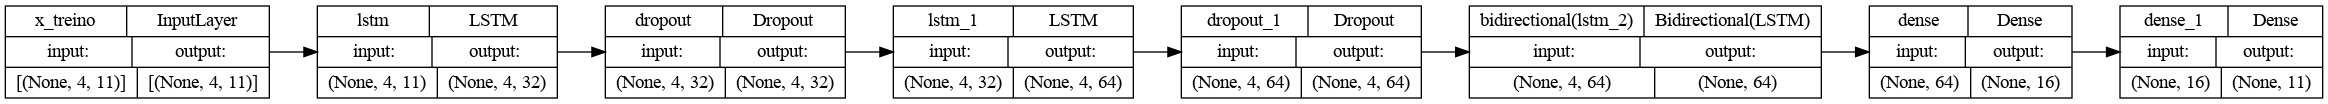

In [29]:
plot_model(modelo_treinado, to_file='modeloLstm.png', show_shapes=True, show_layer_names=True, rankdir='LR')

In [30]:

tensorflow.keras.backend.set_epsilon(1)

#compilando o modelo
otimizador = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

modelo_treinado.compile(loss='mean_squared_error', optimizer=otimizador, metrics=['mae'])

In [31]:
new_model = True
if (new_model == True):
          
    
        
    es = EarlyStopping(monitor='val_loss', mode='min', patience=100)

    '''cp = ModelCheckpoint(filepath='modelos/', 
                           save_weights_only=True, 
                           monitor='loss', 
                           mode='min', 
                           save_best_only=True)'''
    
    #Descomente abaixo e comente o de cima se você estiver usando conjunto de validação
    cp = ModelCheckpoint(filepath='modelos/', 
                           save_weights_only=True, 
                           monitor='val_loss', 
                           mode='min', 
                           save_best_only=True)
    

    historico = modelo_treinado.fit(      x_treino, 
                               y_treino, 
                               validation_data=(x_val, y_val), 
                               epochs=500, 
                               verbose=1, 
                               callbacks=[cp, es], 
                               batch_size=4, 
                               shuffle=False)
    
    np.save('modelos/history_model.npy', historico.history)
    modelo_treinado.load_weights('modelos/')
    modelo_treinado.save('modelos/modelo.h5')
else:
    modelo_treinado = load_model('modelos/modelo.h5')

Epoch 1/500


2023-07-01 22:13:06.907565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 22:13:06.909049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 22:13:06.910230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

145/147 [============================>.] - ETA: 0s - loss: 0.0075 - mae: 0.0340

2023-07-01 22:13:16.384946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 22:13:16.386900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 22:13:16.388204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

147/147 [==============================] - 11s 15ms/step - loss: 0.0075 - mae: 0.0340 - val_loss: 0.0016 - val_mae: 0.0119
Epoch 2/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0060 - mae: 0.0284 - val_loss: 0.0014 - val_mae: 0.0112
Epoch 3/500
147/147 [==============================] - 1s 7ms/step - loss: 0.0057 - mae: 0.0284 - val_loss: 0.0014 - val_mae: 0.0125
Epoch 4/500
147/147 [==============================] - 2s 11ms/step - loss: 0.0055 - mae: 0.0276 - val_loss: 0.0015 - val_mae: 0.0120
Epoch 5/500
147/147 [==============================] - 2s 10ms/step - loss: 0.0054 - mae: 0.0274 - val_loss: 0.0015 - val_mae: 0.0126
Epoch 6/500
147/147 [==============================] - 1s 8ms/step - loss: 0.0052 - mae: 0.0273 - val_loss: 0.0015 - val_mae: 0.0120
Epoch 7/500
147/147 [==============================] - 1s 8ms/step - loss: 0.0051 - mae: 0.0270 - val_loss: 0.0015 - val_mae: 0.0118
Epoch 8/500
147/147 [==============================] - 1s 8ms/step - loss: 0.

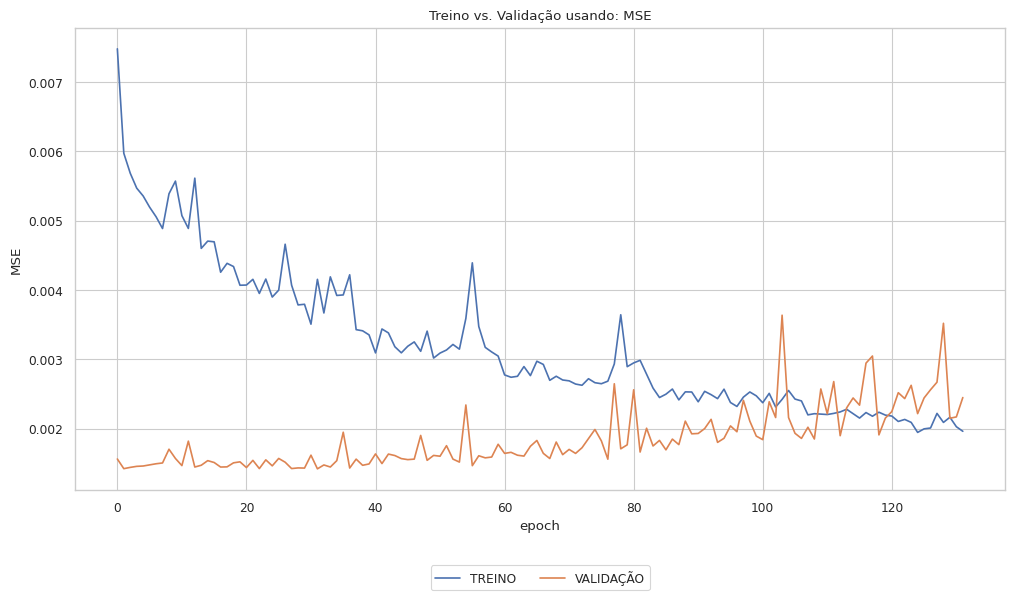

In [32]:
historico=np.load('modelos/history_model.npy', allow_pickle='TRUE').item()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

train_metric = historico['loss']
valid_metric = historico['val_loss']
name_metric = 'mse'

fig = plt.figure()

plt.plot(train_metric, label='TREINO'), 
plt.plot(valid_metric, label='VALIDAÇÃO')
plt.ylabel(name_metric.upper())
plt.xlabel('epoch')
plt.title('Treino vs. Validação usando: ' + name_metric.upper())
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)

plt.show()

In [33]:
#toca um som para avisar que terminou de executar  
pygame.mixer.init()
arquivo_mp3 = 'msc/clash.mp3'
pygame.mixer.music.load(arquivo_mp3)
pygame.mixer.music.play()

while pygame.mixer.music.get_busy():
    continue
    
print('FINALMENTE')

FINALMENTE


2023-07-01 22:16:14.652840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 22:16:14.655088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 22:16:14.657485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 4ms/step
Test RMSE: 2.669


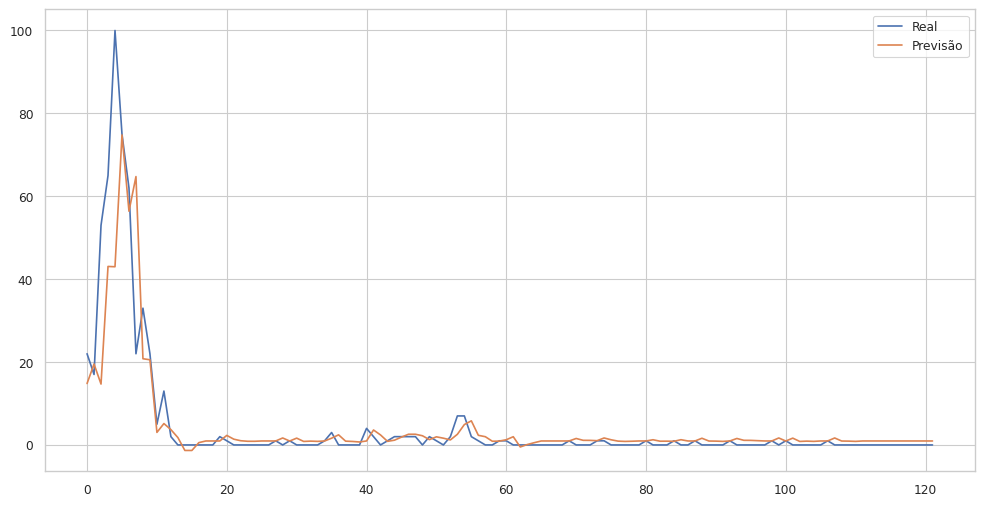

In [34]:
#fazendo as previsoes
previsoes = modelo_treinado.predict(x_teste)

#inverte a normalizacao
previsoes_inverse = scaler.inverse_transform(previsoes)
y_teste_inverse = scaler.inverse_transform(y_teste)

#calculando o erro
rmse = np.sqrt(mean_squared_error(y_teste_inverse, previsoes_inverse))
print('Test RMSE: %.3f' % rmse)

coluna =10 #coluna que queremos analisar (casos totais)
#plotando o grafico
plt.plot(y_teste_inverse[:,coluna], label='Real')
plt.plot(previsoes_inverse[:,coluna], label='Previsão')
plt.legend()
plt.show()



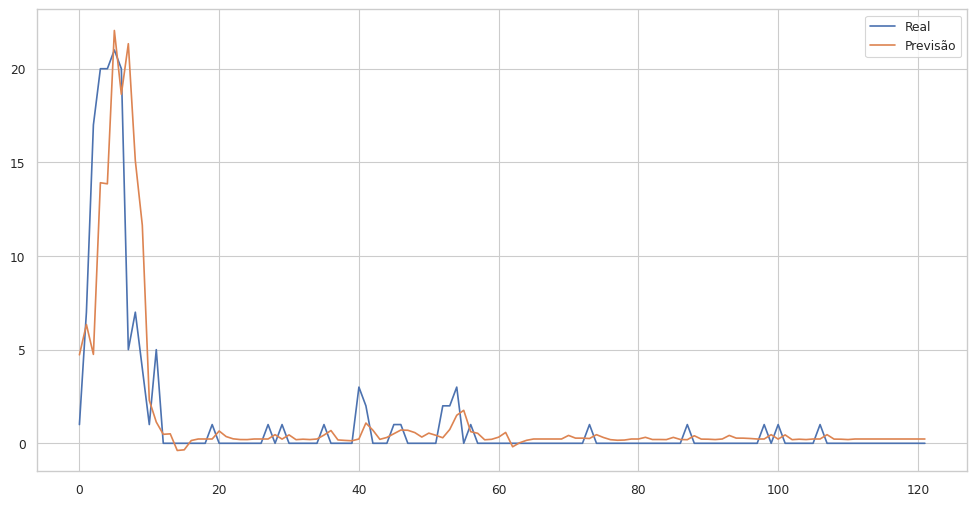

In [35]:
coluna2=5
#plotando o grafico no conjunto de teste para a coluna 5 (faixa etaria 20a34)
plt.plot(y_teste_inverse[:, coluna2], label='Real')
plt.plot(previsoes_inverse[:, coluna2], label='Previsão')
plt.legend()
plt.show()


In [36]:
#calculando alguns erros para a coluna especificada acima neste caso a coluna 10 (casos totais) e imprimindo na tela
print('MAE: %.3f' % mean_absolute_error(y_teste_inverse[:,coluna], previsoes_inverse[:,coluna]))
print('MSE: %.3f' % mean_squared_error(y_teste_inverse[:,coluna], previsoes_inverse[:,coluna]))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(y_teste_inverse[:,coluna], previsoes_inverse[:,coluna])))
print('R2: %.3f' % r2_score(y_teste_inverse[:,coluna], previsoes_inverse[:,coluna]))

MAE: 2.565
MSE: 61.515
RMSE: 7.843
R2: 0.724


In [37]:

#calculando alguns erros para a coluna especificada acima neste caso a coluna 5 (faixa etaria 20a 34 anos) e imprimindo na tela
print('MAE: %.3f' % mean_absolute_error(y_teste_inverse[:,coluna2], previsoes_inverse[:,coluna2]))
print('MSE: %.3f' % mean_squared_error(y_teste_inverse[:,coluna2], previsoes_inverse[:,coluna2]))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(y_teste_inverse[:,coluna2], previsoes_inverse[:,coluna2])))
print('R2: %.3f' % r2_score(y_teste_inverse[:,coluna2], previsoes_inverse[:,coluna2]))


MAE: 0.927
MSE: 5.598
RMSE: 2.366
R2: 0.649


In [38]:
#pegando os valores reais e previstos para a coluna especificada acima neste caso a coluna 10 (casos totais)
y_teste_inverse_flatten = y_teste_inverse[:,coluna].flatten()
previsoes_inverse_flatten = previsoes_inverse[:,coluna].flatten()



In [39]:
y_treino_inverse = scaler.inverse_transform(y_treino)
y_treino_inverse_flatten = y_treino_inverse[:,coluna].flatten()


In [40]:
previsoes2 = modelo_treinado.predict(x_val)
previsoes_inverse2 = scaler.inverse_transform(previsoes2)
y_val_inverse = scaler.inverse_transform(y_val)
y_val_inverse_flatten = y_val_inverse[:,coluna].flatten()
previsoes_inverse2_flatten = previsoes_inverse2[:,coluna].flatten()

4/4 [==============================] - 0s 5ms/step


In [41]:
#calculando alguns erros para a coluna especificada acima neste caso a coluna 10 (casos totais) e imprimindo na tela para o conjunto de validação
print('MAE: %.3f' % mean_absolute_error(y_val_inverse[:,coluna], previsoes_inverse2[:,coluna]))
print('MSE: %.3f' % mean_squared_error(y_val_inverse[:,coluna], previsoes_inverse2[:,coluna]))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(y_val_inverse[:,coluna], previsoes_inverse2[:,coluna])))
print('R2: %.3f' % r2_score(y_val_inverse[:,coluna], previsoes_inverse2[:,coluna]))


MAE: 1.570
MSE: 11.409
RMSE: 3.378
R2: 0.307


In [42]:
#calculando alguns erros para a coluna especificada acima neste caso a coluna 5 (faixa etaria 20a 34 anos) e imprimindo na tela para o conjunto de validação
print('MAE: %.3f' % mean_absolute_error(y_val_inverse[:,coluna2], previsoes_inverse2[:,coluna2]))
print('MSE: %.3f' % mean_squared_error(y_val_inverse[:,coluna2], previsoes_inverse2[:,coluna2]))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(y_val_inverse[:,coluna2], previsoes_inverse2[:,coluna2])))
print('R2: %.3f' % r2_score(y_val_inverse[:,coluna2], previsoes_inverse2[:,coluna2]))


MAE: 0.492
MSE: 1.340
RMSE: 1.158
R2: 0.287


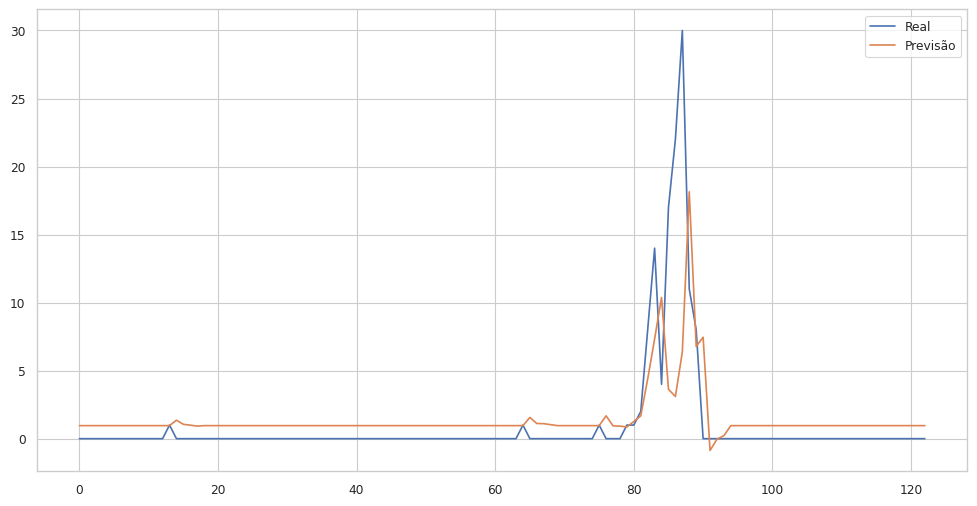

In [43]:
#plotando o grafico onjunto de validação 
plt.plot(y_val_inverse_flatten, label='Real')
plt.plot(previsoes_inverse2[:,coluna], label='Previsão')
plt.legend()
plt.show()


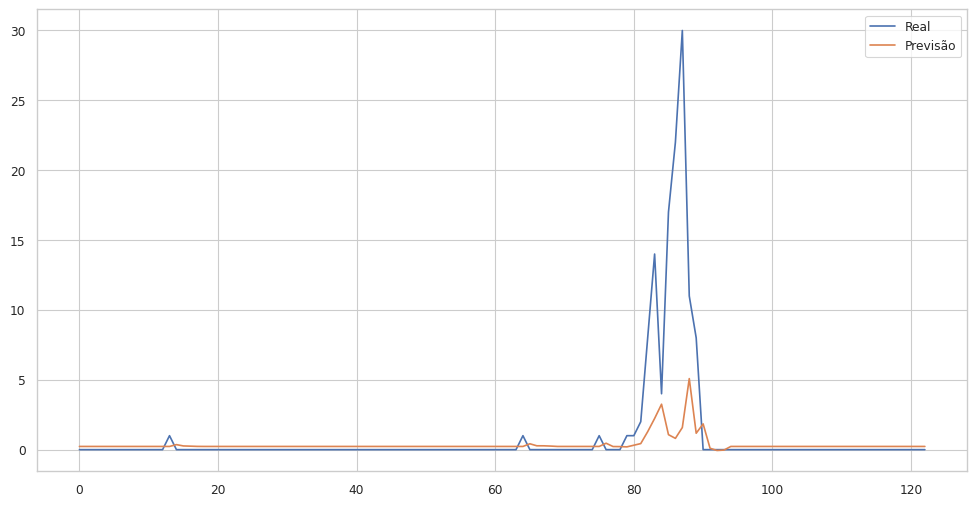

In [44]:
#plotando o grafico da previsao para o conjunto de validação no caso a coluna 5 (faixa etaria 20a 34 anos)
plt.plot(y_val_inverse_flatten, label='Real')
plt.plot(previsoes_inverse2[:,coluna2], label='Previsão')
plt.legend()
plt.show()


In [45]:
#criar um array com 587 valores 0
zeros = np.zeros(587)


df_teste = pd.DataFrame()
df_teste['Real'] = np.hstack((y_treino_inverse_flatten, y_teste_inverse_flatten, y_val_inverse_flatten))
df_teste['Previsao'] = np.hstack((y_treino_inverse_flatten, previsoes_inverse_flatten, previsoes_inverse2_flatten))

df_teste.shape


(832, 2)

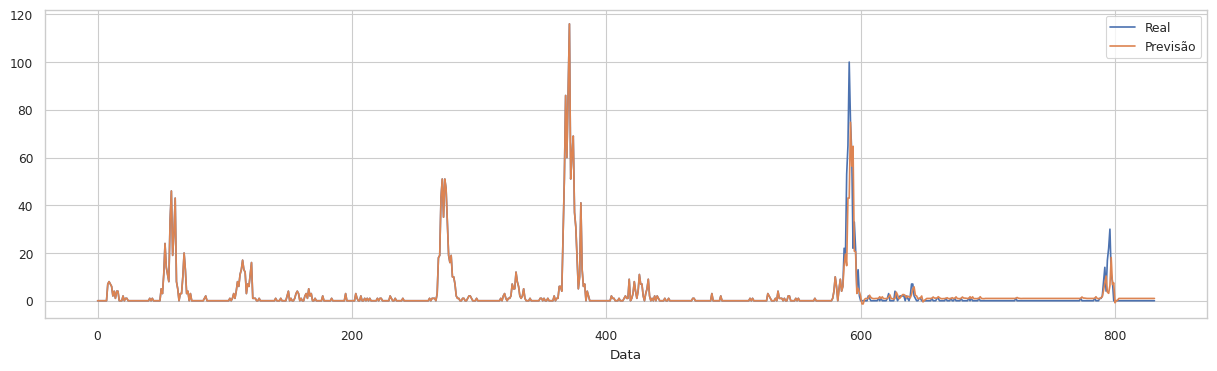

In [46]:
sns.set(rc={'figure.figsize':(15, 4)})
sns.set_style('whitegrid')
sns.set_context('paper')

ax = df_teste.plot(x_compat=True, style='-')
ax.set_xlabel("Data")
ax.legend(["Real", "Previsão"])

plt.grid(True)

plt.show()

plt.close()

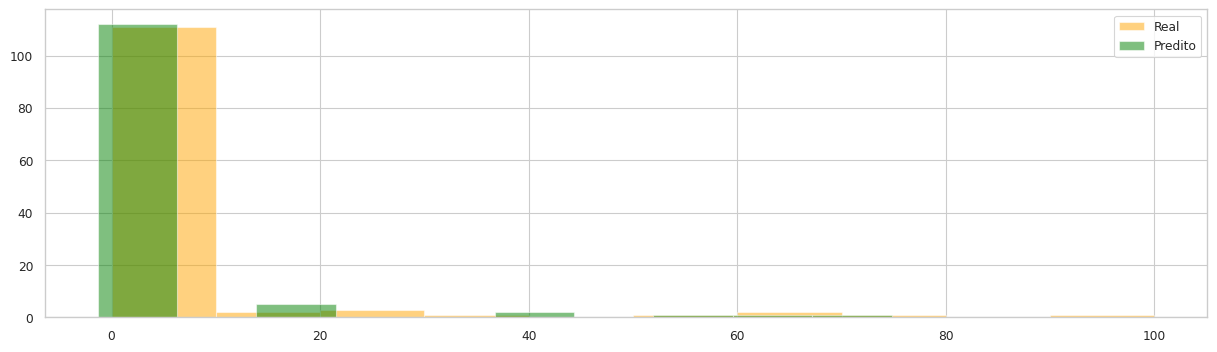

In [47]:
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(figsize=(15, 4))
plt.hist(y_teste_inverse[:,coluna], bins=10, color='orange', alpha=0.5, label='Real')
plt.hist(previsoes_inverse[:,coluna], bins=10, color='green', alpha=0.5, label='Predito')
plt.legend()

plt.show()

plt.close()

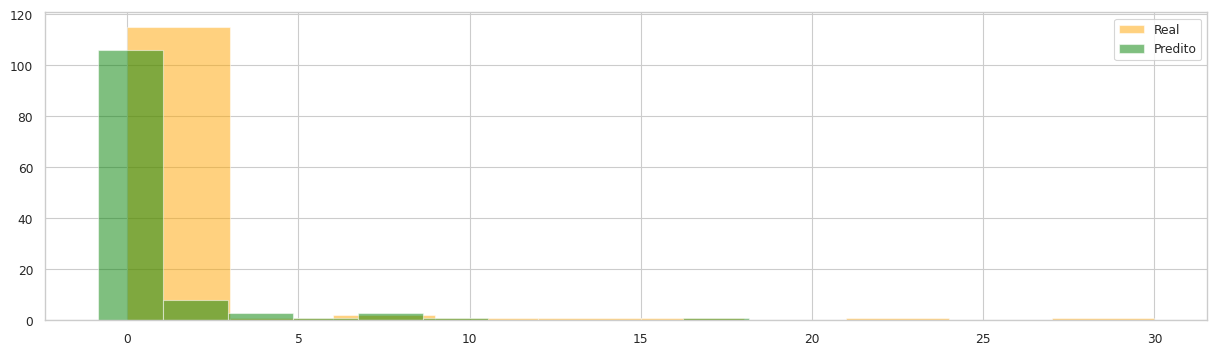

In [48]:
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(figsize=(15, 4))
plt.hist(y_val_inverse[:,coluna], bins=10, color='orange', alpha=0.5, label='Real')
plt.hist(previsoes_inverse2[:,coluna], bins=10, color='green', alpha=0.5, label='Predito')
plt.legend()

plt.show()

plt.close()